In [1]:
# Model training and saving


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set the paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/Data/Organized_data/train_set'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Data/Organized_data/validation_set'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Data/Organized_data/test_set'

# Image size expected by MobileNetV2
img_size = (224, 224)

# Data augmentation and preprocessing for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data preprocessing for validation and test sets
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create image generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='binary'
)

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=5, validation_data=val_generator)

# Save the trained model to a file
model.save('/content/drive/MyDrive/Colab Notebooks/Data/Models/poisonous_plant_model.h5')


Found 4300 images belonging to 4 classes.
Found 480 images belonging to 4 classes.
9406464/9406464 [==============================] - 0s 0us/step


Epoch 1/5
135/135 [==============================] - 1496s 11s/step - loss: -416.0580 - accuracy: 0.1672 - val_loss: -1004.5024 - val_accuracy: 0.1667
Epoch 2/5
135/135 [==============================] - 305s 2s/step - loss: -2619.6919 - accuracy: 0.1674 - val_loss: -3885.4954 - val_accuracy: 0.1667
Epoch 3/5
135/135 [==============================] - 306s 2s/step - loss: -7072.9150 - accuracy: 0.1674 - val_loss: -8736.7598 - val_accuracy: 0.1667
Epoch 4/5
135/135 [==============================] - 311s 2s/step - loss: -13848.2627 - accuracy: 0.1674 - val_loss: -15524.7588 - val_accuracy: 0.1667
Epoch 5/5
135/135 [==============================] - 312s 2s/step - loss: -22832.3574 - accuracy: 0.1674 - val_loss: -24118.3535 - val_accuracy: 0.1667


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Set the paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/Data/Organized_data/train_set'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Data/Organized_data/validation_set'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Data/Organized_data/test_set'

# Image size expected by MobileNetV2
img_size = (224, 224)

# Data augmentation and preprocessing for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data preprocessing for validation and test sets
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create image generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'  # Use categorical class mode
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'  # Use categorical class mode
)

# Calculate class weights to address class imbalance
class_weights = compute_class_weight('balanced', classes=train_generator.classes, y=train_generator.classes)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for multi-class classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
num_classes = len(train_generator.class_indices)  # Get the number of classes dynamically
x = Dense(num_classes, activation='softmax')(x)  # Use softmax activation for multi-class classification

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with an increased number of epochs
model.fit(train_generator, epochs=15, validation_data=val_generator, class_weight=class_weights)

# Save the trained model to a file
model.save('/content/drive/MyDrive/Colab Notebooks/Data/Models/poisonous_plant_model_updated.h5')


Found 4300 images belonging to 4 classes.
Found 480 images belonging to 4 classes.
Epoch 1/15
135/135 [==============================] - 345s 3s/step - loss: 1.6968 - accuracy: 0.5535 - val_loss: 0.9715 - val_accuracy: 0.6125
Epoch 2/15
135/135 [==============================] - 298s 2s/step - loss: 1.3981 - accuracy: 0.6321 - val_loss: 0.9531 - val_accuracy: 0.6167
Epoch 3/15
135/135 [==============================] - 318s 2s/step - loss: 1.3092 - accuracy: 0.6537 - val_loss: 0.8472 - val_accuracy: 0.6708
Epoch 4/15
135/135 [==============================] - 309s 2s/step - loss: 1.2202 - accuracy: 0.6853 - val_loss: 0.8379 - val_accuracy: 0.6604
Epoch 5/15
135/135 [==============================] - 314s 2s/step - loss: 1.1726 - accuracy: 0.6984 - val_loss: 0.8385 - val_accuracy: 0.6687
Epoch 6/15
135/135 [==============================] - 315s 2s/step - loss: 1.1548 - accuracy: 0.7051 - val_loss: 0.8313 - val_accuracy: 0.6729
Epoch 7/15
135/135 [==============================] - 288s 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Evaluate the model on the test set
test_generator.reset()  # Reset the generator to the beginning
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to class labels
predicted_classes = tf.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
class_report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(class_report)

# Compute accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")


38/38 [==============================] - 67s 2s/step
Confusion Matrix:
[[157   9  12  14]
 [ 60  77  34  29]
 [ 45  26 435  96]
 [  7   6  13 177]]
Classification Report:
                     precision    recall  f1-score   support

Atlantic_Poison_Oak       0.58      0.82      0.68       192
 Eastern_Poison_Ivy       0.65      0.39      0.48       200
      Not_Poisonous       0.88      0.72      0.79       602
       Poison_Sumac       0.56      0.87      0.68       203

           accuracy                           0.71      1197
          macro avg       0.67      0.70      0.66      1197
       weighted avg       0.74      0.71      0.71      1197

Accuracy: 70.68%


38/38 [==============================] - 63s 2s/step


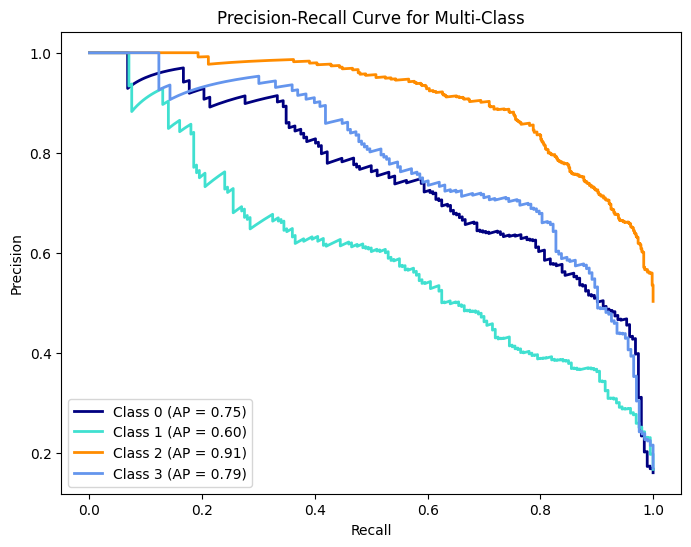

In [51]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Convert predictions to probabilities
probabilities = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Get true labels
true_classes = test_generator.classes

# Convert true labels to one-hot encoding
true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=num_classes)

# Initialize precision, recall, and average precision dictionaries
precision = dict()
recall = dict()
average_precision = dict()

# Compute precision-recall curve for each class
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_classes_one_hot[:, i], probabilities[:, i])
    average_precision[i] = auc(recall[i], precision[i])

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue']  # Adjust colors based on your number of classes

for i, color in zip(range(num_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class')
plt.legend(loc='best')
plt.show()


38/38 [==============================] - 69s 2s/step


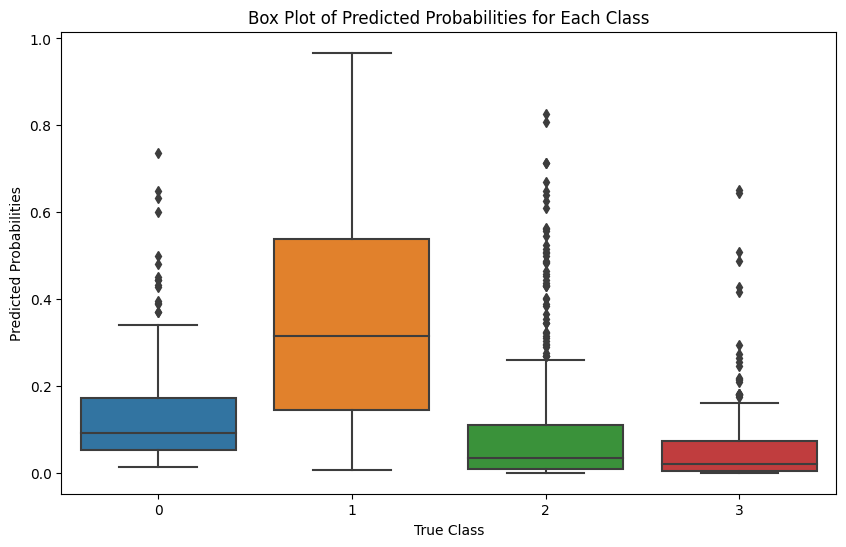

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predictions to probabilities
probabilities = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Get true labels
true_classes = test_generator.classes

# Convert true labels to one-hot encoding
true_classes_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=num_classes)

# Create a DataFrame for easier plotting
import pandas as pd

data = {'True Class': true_classes, 'Predicted Probabilities': probabilities[:, 1]}  # Assuming binary classification
df = pd.DataFrame(data)

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='True Class', y='Predicted Probabilities', data=df)
plt.title('Box Plot of Predicted Probabilities for Each Class')
plt.show()


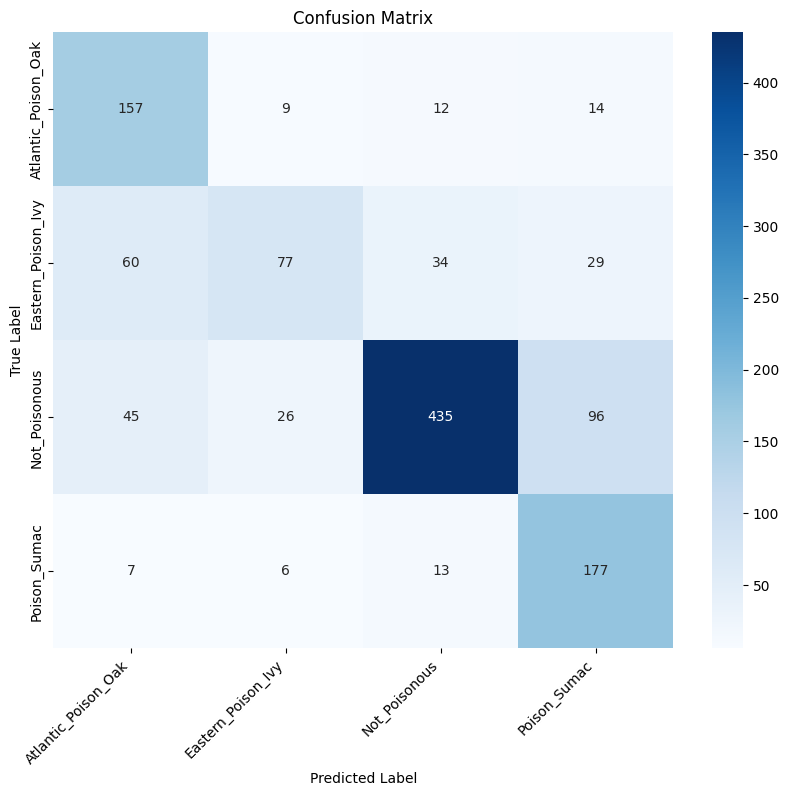

In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming predictions are class labels
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap with seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())

# Add title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()


In [48]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Data/Models/poisonous_plant_model_updated.h5')

# Define the path to the image you want to predict
image_path = '/content/drive/MyDrive/Colab Notebooks/Data/dataset/non_poisonous_image_path/Corn Plant.jpg'

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make a prediction
predictions = loaded_model.predict(img_array)

# Get the predicted class label with the highest probability
predicted_class_index = np.argmax(predictions)
predicted_class_label = list(train_generator.class_indices.keys())[predicted_class_index]

# Display the prediction result
if predicted_class_label == 'Not_Poisonous':
    print('The image is predicted to be: Non-Poisonous')
else:
    print(f'The image is predicted to be: Poisonous')


1/1 [==============================] - 1s 1s/step
The image is predicted to be: Non-Poisonous
